In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

### Описание данных
#### ads_data.csv – данные взаимодействий с рекламными объявлениями  
date – дата  
time – время  
event – действие (просмотр/клик)  
platform – платформа  
ad_id – id объявления  
client_union_id – id рекламного кабинета  
campaign_union_id – id рекламной кампании  
ad_cost_type – тип оплаты  
ad_cost – цена  
has_video – есть ли видео  
target_audience_count – размер аудитории  

#### ads_clients_data.csv – характеристики рекламных клиентов  
date – дата  
client_union_id – id рекламного кабинета  
community_id – id сообщества  
create_date – дата создания рекламного клиента  

1. Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

In [3]:
# Ссылка с данными ads_data.csv
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/dCp_Ifqy7ClVVQ'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [4]:
ads_data = pd.read_csv(download_url, parse_dates=['date', 'time'])
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [5]:
# Для расчета посчитаем количество кликов и показов у каждого объявления
# Далее поделим полученные числа на количество объявлений и округлим до целого
ads_data \
    .groupby('event') \
    .agg({'ad_id': 'count'}) \
    .div(ads_data.ad_id.nunique()) \
    .round()

,ad_id
event,
click,113.0
view,923.0


2. Давайте посмотрим на распределение показов объявлений! Прологарифмируйте число показов, а затем постройте такой график, чтобы можно было понять форму распределения

In [6]:
# Посчитаем количество показов у каждого объявления
add_view = ads_data \
            .query('event=="view"') \
            .groupby('ad_id',as_index=False) \
            .agg({'platform': 'count'}) \
            .rename(columns={'platform': 'number_views'})

In [7]:
# Прологарифмируем полученное значение показов
add_view.number_views = np.log(add_view.number_views)

In [8]:
add_view.head()

,ad_id,number_views
0,2,4.615121
1,3,5.214936
2,1902,3.713572
3,2064,3.555348
4,2132,4.060443


In [9]:
# Посчитаем количество объявлений с прологарифмированным количеством просмотров
number_views_per_click = add_view \
                        .groupby('number_views',as_index=False) \
                        .agg({'ad_id': 'count'}) \
                        .rename(columns={'ad_id': 'number_adds'})
number_views_per_click

,number_views,number_adds
0,2.302585,1
1,2.397895,2
2,2.564949,4
3,2.639057,3
4,2.708050,6
...,...,...
377,9.886748,1
378,10.092122,1
379,10.858922,1
380,12.125925,1


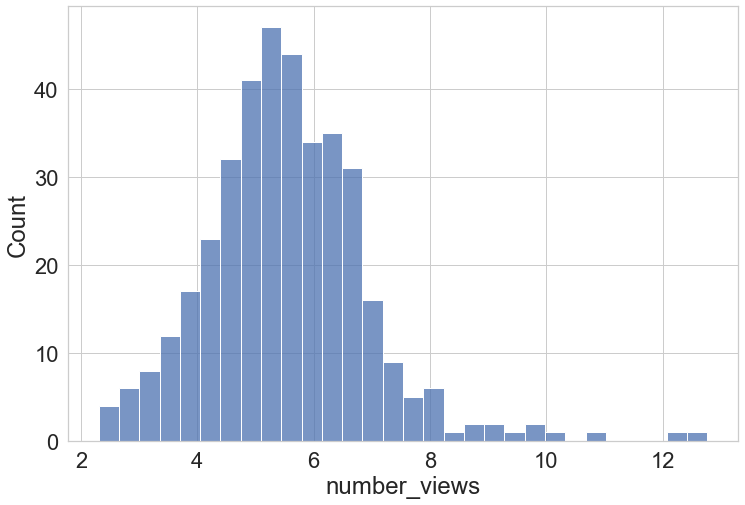

In [10]:
# Строим гистограмму прологарифмированных значений
plt.figure(figsize=(12,8))
sns.histplot(number_views_per_click.number_views, bins=30)
plt.show()

3. Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

In [11]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [12]:
# Расчитываем количество рекламы в день со скользящим средним
view_per_date_roll = ads_data \
                    .query('event == "view"') \
                    .groupby(['date', 'ad_id'], as_index=False) \
                    .agg({'event': 'count'}) \
                    .pivot(columns='date', index='ad_id', values='event') \
                    .mean() \
                    .rolling(2) \
                    .mean()
view_per_date_roll.head()

date
2019-04-01           NaN
2019-04-02    146.134626
2019-04-03    150.869880
2019-04-04    419.927249
2019-04-05    797.505699
dtype: float64

4. Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).  
Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd

In [13]:
#Среднее количество рекламы в день
view_per_date = ads_data \
                    .query('event == "view"') \
                    .groupby(['date', 'ad_id'], as_index=False) \
                    .agg({'event': 'count'}) \
                    .pivot(columns='date', index='ad_id', values='event') \
                    .mean()
view_per_date

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [14]:
# Объединяем среднее и скользящее среднее в один датайрем
view_mean = pd.DataFrame()
view_mean['mean'], view_mean['roll'] = view_per_date, view_per_date_roll

<AxesSubplot:xlabel='date'>

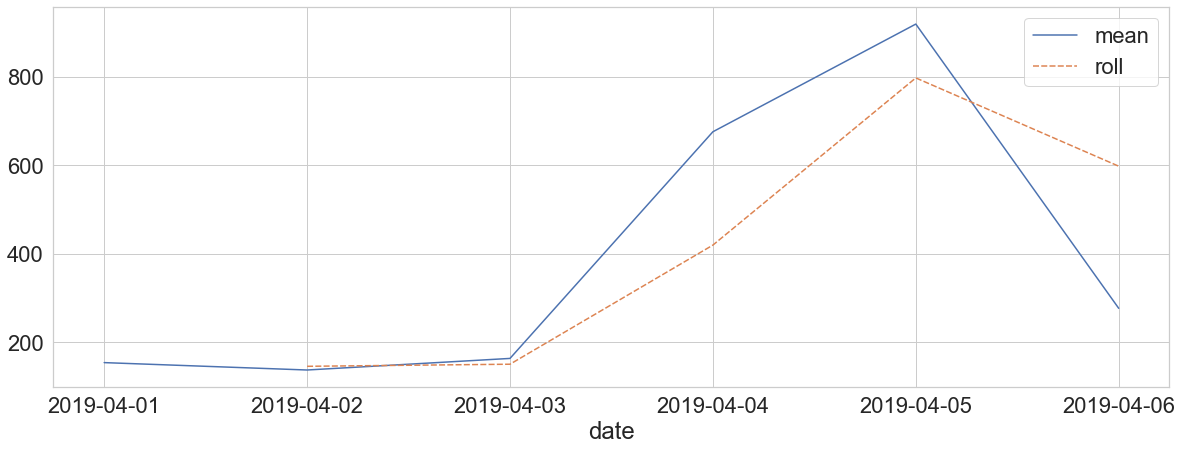

In [15]:
# Строим график со средним и скользящим средним количеством показов рекламы в день
sns.lineplot(data=view_mean)

In [16]:
# Расчитываем разницу между средними по дням
abs(view_mean['mean'] - view_mean['roll']).idxmax()

Timestamp('2019-04-06 00:00:00')

Ответ: 2019-04-06

5. 
Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

В качестве ответа укажите среднее число дней.


In [17]:
# Ссылка с данными ads_clients_data.csv
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/UAqlGL01qhPJgw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']


In [18]:
# Загружаем данные о клиентах
ads_clients_data = pd.read_csv(download_url, parse_dates=['date', 'create_date'])

In [19]:
reklama_union = ads_data.merge(ads_clients_data, on='client_union_id')

In [20]:
reklama_union

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2019-04-04,2019-04-04 18:07:25,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999996,2019-04-04,2019-04-04 18:29:06,view,ios,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999997,2019-04-04,2019-04-04 18:55:46,view,web,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04
999998,2019-04-04,2019-04-04 19:21:09,view,android,43921,30712,43920,CPM,196.7,0,7807,2020-05-07,-130652663,2019-03-04


In [21]:
# Считаем среднее количество дней между первым рекламным объявлением и датой создания аккаунта
reklama_union \
    .drop_duplicates(subset=['client_union_id']) \
    .create_date \
    .subtract(reklama_union['date_x']) \
    .abs() \
    .mean()

Timedelta('124 days 15:27:55.417661098')

Ответ: 124 дней

6. Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы

In [22]:
# Считаем количество пользователей, которые публиковали рекламу
reklama_union \
    .drop_duplicates(subset=['client_union_id']) \
    .shape[0]

838

In [23]:
# Считаем общее количество пользователей, которые зарегистрировались
ads_clients_data.client_union_id.nunique()

122078

In [24]:
# Считаем соотношение пользователей, которые выкладывали рекламу от общего количества
round(838 / 122078 * 100, 2)

0.69

7. Давайте разобъем наших клиентов по промежуткам [0, 30, 90, 180, 365] от создания рекламного кабинета до запуска первого рекламного объявления.

In [25]:
# Посчитаем сколько прошло дней между регистрацией и датой первого объявления
reklama_union['first_work'] = reklama_union \
                            .drop_duplicates(subset=['client_union_id']) \
                            .date_x \
                            .subtract(reklama_union['create_date']) \
                            .abs()

In [26]:
reklama_union.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,first_work
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,NaT
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,NaT
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,NaT
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,NaT


In [27]:
# Отберем тех пользователей, которые выкладывали объявление
first_ads = reklama_union.loc[reklama_union.first_work.isna() == False]

In [28]:
first_ads['speed_work'] = pd.cut(first_ads.first_work, pd.to_timedelta(['0d', '30d', '90d', '180d', '360d']), labels=['sonic', 'gepard', 'dog', 'slowpoke'])

In [29]:
first_ads.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,first_work,speed_work
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days,dog
801,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011,2020-05-07,-130337958,2018-12-25,97 days,dog
1384,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410,2020-05-07,-130393498,2018-11-13,139 days,dog
1459,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711,2020-05-07,-130929771,2018-08-18,226 days,slowpoke
1720,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501,2020-05-07,-130021201,2019-02-22,38 days,gepard


8. постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них

C:\Users\Vlad_Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


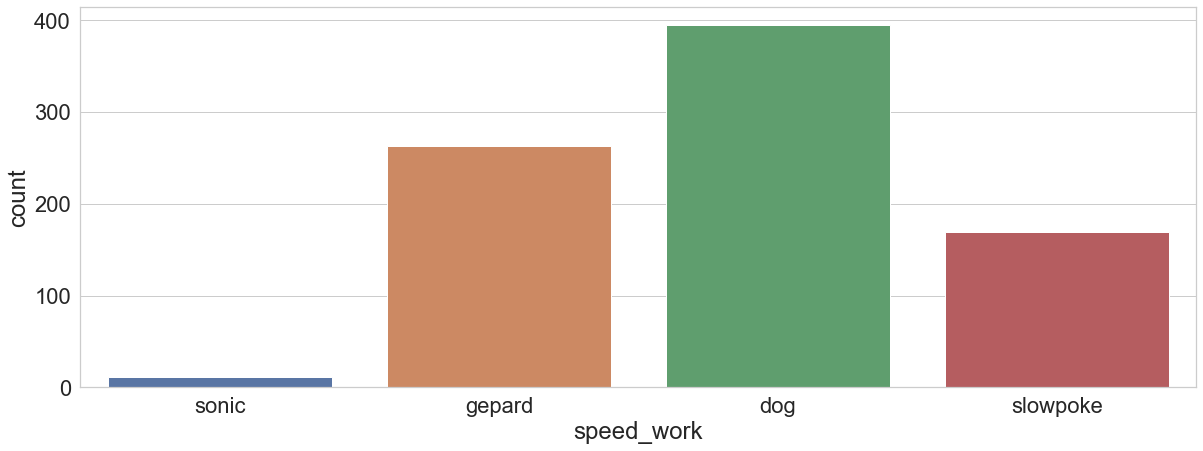

In [30]:
sns.countplot(first_ads.speed_work)
plt.show()